In [2]:
import pandas as pd
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import scipy

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import glmnet as gln

from tqdm.notebook import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

In [4]:
z=pd.read_csv("GKX_20201231.csv")
z[z["DATE"==19570331]]

        permno      DATE       mvel1       RET      prc  SHROUT      beta  \
100000   10225  19380430  176387.250  0.154008  68.3750    2977  0.358450   
100001   10233  19380430   14487.750  0.276596   7.5000    2466  1.295683   
100002   10241  19380430  186168.500  0.142857  85.0000    2474  0.519771   
100003   10268  19380430     908.375  0.192308   1.9375     559  0.960609   
100004   10276  19380430    3040.125  0.179104   9.8750     363  0.819230   
...        ...       ...         ...       ...      ...     ...       ...   
199995   28281  19480430   23100.000  0.051948  20.2500    1200  1.069929   
199996   28513  19480430    8262.000  0.086420  22.0000     408  0.940367   
199997   53023  19480430    5896.625  0.124224  22.6250     293       NaN   
199998   75471  19480430     875.000 -0.080000  11.5000      70  0.710834   
199999   86239  19480430   16482.375  0.034188  15.1250    1127  1.542248   

          betasq     chmom    dolvol  ...  baspread           ill    maxret

In [22]:
z1=z[308642:4068674]
z1.index=range(len(z1))

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
z11 = imputer.fit_transform(z1)

In [26]:
z11=pd.DataFrame(z11,columns=z1.columns)

In [28]:
z11.to_csv('newrealdat.csv', index=False)

In [426]:
z11

          permno    DATE         mvel1       RET        prc   SHROUT  \
0        10006.0  1957.0  8.630850e+04  0.018405  62.250000   1412.0   
1        10014.0  1957.0  3.903375e+03  0.000000   2.625000   1487.0   
2        10022.0  1957.0  9.841000e+03 -0.003846   6.375000   1514.0   
3        10030.0  1957.0  5.190100e+04  0.077907  45.750000   1207.0   
4        10057.0  1957.0  3.525000e+04 -0.017730  69.250000    500.0   
...          ...     ...           ...       ...        ...      ...   
3760027  93427.0  2016.0  1.577480e+06 -0.058411  40.299999  36857.0   
3760028  93428.0  2016.0  1.250976e+06 -0.006024  41.250000  30353.0   
3760029  93429.0  2016.0  5.600537e+06  0.072424  73.889999  81285.0   
3760030  93433.0  2016.0  2.473625e+04 -0.127273  13.000000   8995.0   
3760031  93434.0  2016.0  8.573280e+04 -0.041667   4.600000  17948.0   

             beta    betasq     chmom     dolvol  ...  baspread           ill  \
0        1.117907  1.249717  0.134574  10.296745  ... 

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
z0 = imputer.fit_transform(z)

In [16]:
z0.index=range(len(z0))
z0.to_csv('newdat.csv', index=False)

In [33]:
z0=pd.read_csv("newdat.csv")

In [241]:
train=z0.iloc[0:int(len(z0)*18/60)]
validation=z0.iloc[int(len(z0)*18/60):int(len(z0)*30/60)]
test=z0.iloc[int(len(z0)*30/60):]

In [242]:
validation.index=range(len(validation))
test.index=range(len(test))

In [243]:
Xtrain=train.drop(columns=["RET","permno","DATE"])
Xvalid=validation.drop(columns=["RET","permno","DATE"])
Xtest=test.drop(columns=["RET","permno","DATE"])

In [244]:
ytrain=train["RET"]
yvalid=validation["RET"]
ytest=test["RET"]

In [245]:
X=z0.drop(columns=["permno","RET","DATE"])
y=z0["RET"]

In [246]:
mtrain=ytrain.mean()
mvalid=yvalid.mean()
mtest=ytest.mean()
ytrain_dm=ytrain-mtrain
yvalid_dm=yvalid-mvalid
ytest_dm=ytest-mtest

In [247]:
import sklearn.preprocessing as sp

In [435]:
##OLS
from sklearn import linear_model
import numpy as np
grid = 10**np.linspace(10,-2,100)
regr = linear_model.LinearRegression()
regr.fit(scale(Xtrain),ytrain_dm)

LinearRegression()

In [355]:
pred_is=regr.predict(scale(Xtrain))+mtrain
pred_oos=regr.predict(scale(Xtest))+mtrain

In [356]:
r2_is_ols=1-((pred_is-ytrain)**2).sum()/((ytrain-mtrain)**2).sum()
r2_is_ols

0.049536406653404974

In [357]:
r2_oos_ols=1-((pred_oos-ytest)**2).sum()/((ytest-mtrain)**2).sum()
r2_oos_ols

0.021444350474495777

In [358]:
regr.score(scale(Xtest),ytest_dm)

0.02144964068794275

In [436]:
pd.Series(regr.coef_, index=Xtrain.columns)

mvel1       -0.299018
prc          0.009466
SHROUT      -0.000398
beta        -0.002052
betasq       0.001870
               ...   
std_turn     0.001361
zerotrade   -0.006468
sic2         0.000612
bm          -0.000120
bm_ia       -0.000115
Length: 98, dtype: float64

In [199]:
regr.score(sp.scale(Xtest),ytest_dm)

0.02144964068794275

In [433]:
##OLS+H
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor().fit(scale(Xtrain), ytrain_dm)

In [359]:
huber.score(scale(Xtest), ytest_dm)

0.014532251683376352

In [434]:
pd.Series(huber.coef_, index=Xtrain.columns)

mvel1       -0.508933
prc          0.011221
SHROUT       0.001609
beta        -0.001842
betasq       0.001977
               ...   
std_turn     0.001014
zerotrade   -0.003555
sic2         0.000699
bm          -0.000033
bm_ia       -0.000088
Length: 98, dtype: float64

In [431]:
##OLS3+H
X3train=train[["mvel1","bm","mom1m"]]
X3test=test[["mvel1","bm","mom1m"]]
huber2 = HuberRegressor().fit(scale(X3train), ytrain_dm)
huber2.score(scale(X3test), ytest_dm)

-0.003530208018998504

In [432]:
pd.Series(huber2.coef_, index=X3train.columns)

mvel1    0.001459
bm       0.000204
mom1m   -0.002224
dtype: float64

In [261]:
##Ridge
from sklearn import linear_model
import sklearn.metrics
ridgecv = RidgeCV(alphas=alphas, scoring='r2')
ridgecv.fit(scale(Xvalid), yvalid_dm)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        scoring='r2')

In [269]:
ridgecv.alpha_

7.087370814634009

In [272]:
ridge2 = Ridge(alpha=ridgecv.alpha_)
ridge2.fit(scale(Xtrain), ytrain_dm)

Ridge(alpha=7.087370814634009)

In [273]:
pred_is=ridge2.predict(scale(Xtrain))+mtrain
r2_is_ridge=1-((pred_is-ytrain)**2).sum()/((ytrain-mtrain)**2).sum()
r2_is_ridge

0.04953633572874672

In [276]:
pred_oos=ridge2.predict(scale(Xtest))+mtrain
r2_oos_ridge=1-((pred_oos-ytest)**2).sum()/((ytest-mtrain)**2).sum()
r2_oos_ridge

0.021430646713493373

In [274]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

mvel1       -0.298611
prc          0.009468
SHROUT      -0.000398
beta        -0.002052
betasq       0.001870
               ...   
std_turn     0.001361
zerotrade   -0.006468
sic2         0.000613
bm          -0.000120
bm_ia       -0.000115
Length: 98, dtype: float64

In [424]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(Xvalid), yvalid_dm)

LassoCV(cv=10, max_iter=10000)

In [425]:
lassocv.alpha_

6.334826608683498e-05

In [426]:
lasso = Lasso(max_iter=10000)
coefs = []
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(Xtrain), ytrain_dm)

Lasso(alpha=6.334826608683498e-05, max_iter=10000)

In [428]:
pd.Series(lasso.coef_, index=X.columns)

mvel1       -0.285369
prc          0.009393
SHROUT      -0.000231
beta        -0.000664
betasq       0.000519
               ...   
std_turn     0.001236
zerotrade   -0.006194
sic2         0.000571
bm          -0.000043
bm_ia       -0.000085
Length: 98, dtype: float64

In [290]:
pred_oos=lasso.predict(scale(Xtest))+mtrain
r2_oos_lasso=1-((pred_oos-ytest)**2).sum()/((ytest-mtrain)**2).sum()
r2_oos_lasso

0.02151802809592762

In [303]:
##Elastic net
##alpha=0(Ridge)
grid = 10**np.linspace(10,-2,100)
ridge5 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge5.fit(scale(Xvalid), yvalid_dm)

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           scoring='mean_squared_error', tol=1e-12)

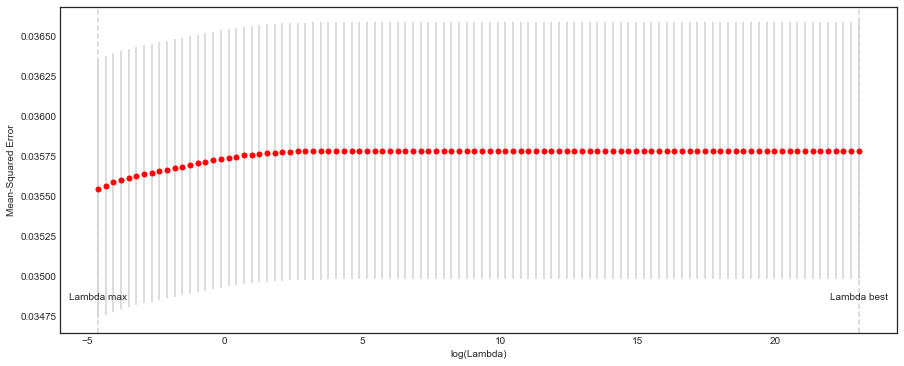

In [304]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [313]:
pred_oos= ridge5.predict(scale(Xtest), lamb=ridge5.lambda_max_)+mtrain
r2_oos_r5=1-((pred_oos-ytest)**2).sum()/((ytest-mtrain)**2).sum()
r2_oos_r5

0.003937493442550788

In [420]:
pd.Series(np.round(ridge5.coef_path_[:,ridge5.lambda_max_inx_], decimals=3), index=X.columns)

mvel1       -0.019
prc          0.002
SHROUT      -0.002
beta        -0.001
betasq       0.001
             ...  
std_turn     0.004
zerotrade   -0.005
sic2         0.000
bm           0.001
bm_ia       -0.000
Length: 98, dtype: float64

In [366]:
##Elastic net
from sklearn.linear_model import ElasticNet
elastic_net=gln.ElasticNet(alpha=0.5,scoring='mean_squared_error', n_splits=10)
elastic_net.fit(scale(Xvalid),yvalid_dm)

ElasticNet(alpha=0.5, n_splits=10, scoring='mean_squared_error')

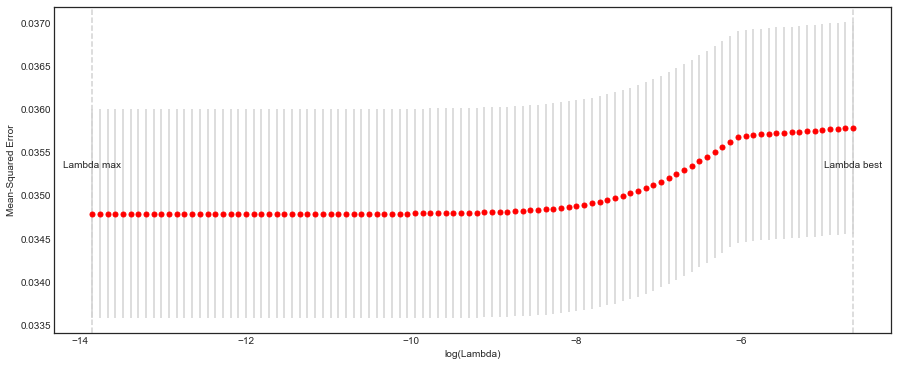

In [367]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(elastic_net.lambda_path_), -elastic_net.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=elastic_net.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([elastic_net.lambda_best_, elastic_net.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [368]:
pred_oos= elastic_net.predict(scale(Xtest),lamb=elastic_net.lambda_max_)+mtrain
r2_oos_en=1-((pred_oos-ytest)**2).sum()/((ytest-mtrain)**2).sum()
r2_oos_en

0.028355607316954745

In [419]:
##parameters
pd.Series(np.round(elastic_net.coef_path_[:,elastic_net.lambda_max_inx_], decimals=3), index=X.columns)

mvel1       -0.341
prc          0.001
SHROUT      -0.002
beta        -0.001
betasq       0.001
             ...  
std_turn     0.004
zerotrade   -0.006
sic2         0.000
bm           0.001
bm_ia       -0.000
Length: 98, dtype: float64

In [378]:
##PCR
pca = PCA()
Xtrain_reduced = pca.fit_transform(scale(Xtrain))
Xvalid_reduced = pca.fit_transform(scale(Xvalid))
Xtest_reduced=pca.fit_transform(scale(Xtest))
print(pca.components_.shape)

(98, 98)


In [379]:
X_reduced.shape

(1128641, 98)

In [382]:
regr4 = linear_model.LinearRegression()
regr4.fit(scale(Xtrain_reduced),ytrain_dm)

LinearRegression()

In [384]:
regr4.score(scale(Xtest_reduced),ytest_dm)

-0.08399400164985704

In [380]:
from sklearn.linear_model import HuberRegressor
huber3 = HuberRegressor().fit(scale(Xtrain_reduced), ytrain_dm)

In [381]:
huber3.score(scale(Xtest_reduced),ytest_dm)

-0.17052761910841685

In [385]:
##macroeconomic preditors
mac=pd.read_csv("PredictorData2020.csv")

In [393]:
aver_ret=[]
for i in z0["DATE"].unique():
    temp=z0[z0["DATE"]==i]
    me=temp["RET"].mean()
    aver_ret.append(me)
aver_ret

[0.0036899088319088313,
 -0.02343245299145299,
 0.02254809451795841,
 0.025724515580736542,
 0.022103457627118638,
 -0.006728544943820219,
 0.005661613295880148,
 -0.05027726492537312,
 -0.05287622625698323,
 -0.06553309040074556,
 0.021125447761194027,
 -0.04890783379758588,
 0.10669051588785046,
 -0.011997899159663861,
 0.0358383133208255,
 0.030076584112149526,
 0.03937807383177569,
 0.03155172056074766,
 0.054219280487804875,
 0.029697196244131446,
 0.05203505816135083,
 0.0329213875823142,
 0.04220830385700846,
 0.038807275117370886,
 0.04152691838649155,
 0.02811250187969924,
 0.011859142857142856,
 0.025263066792097836,
 0.008156429373246026,
 0.00422286274509804,
 0.03015191433891992,
 -0.01487480444856348,
 -0.04576005653382761,
 0.02325280203515263,
 0.015130579870729457,
 0.021147655616942904,
 -0.039170059852670344,
 0.008493452708907254,
 -0.024888160256410247,
 -0.019577219890510946,
 0.025538057534246573,
 0.021598838797814202,
 -0.019348305530371705,
 0.0380078844765342

In [400]:
ret=pd.DataFrame(aver_ret,columns=["ret"])
data=pd.concat([mac,ret],axis=1)
data

     yyyymm        dp        ep        bm      ntis     tbl     tms     dfy  \
0    195701 -1.410777 -1.118168  0.567243  0.027992  0.0311  0.0017  0.0072   
1    195702 -1.397213 -1.104186  0.584994  0.030173  0.0310  0.0018  0.0080   
2    195703 -1.406491 -1.113058  0.599819  0.026600  0.0308  0.0023  0.0077   
3    195704 -1.422250 -1.127962  0.576098  0.027421  0.0307  0.0038  0.0077   
4    195705 -1.438007 -1.142879  0.564039  0.028849  0.0306  0.0042  0.0078   
..      ...       ...       ...       ...       ...     ...     ...     ...   
715  201608 -1.685012 -1.390361  0.315197 -0.030723  0.0030  0.0156  0.0092   
716  201609 -1.682653 -1.386284  0.316794 -0.032543  0.0029  0.0167  0.0090   
717  201610 -1.671969 -1.368982  0.319688 -0.028976  0.0033  0.0187  0.0087   
718  201611 -1.684409 -1.374967  0.303286 -0.027373  0.0045  0.0222  0.0085   
719  201612 -1.690099 -1.374360  0.293479 -0.025027  0.0051  0.0221  0.0077   

         svar       ret  
0    0.000902  0.003690  

In [402]:
train2=data.iloc[0:int(len(mac)*18/60)]
valid2=data.iloc[int(len(mac)*18/60):int(len(mac)*30/60)]
test2=data.iloc[int(len(mac)*30/60):]

In [461]:
xtrain2=train2.drop(columns=["ret","yyyymm"])
xvalid2=valid2.drop(columns=["ret","yyyymm"])
xtest2=test2.drop(columns=["ret","yyyymm"])

In [462]:
ytrain2=train2["ret"]
yvalid2=valid2["ret"]
ytest2=test2["ret"]

In [463]:
mtrain2=ytrain2.mean()
mvalid2=yvalid2.mean()
mtest2=ytest2.mean()
ytrain2_dm=ytrain2-mtrain2
yvalid2_dm=yvalid2-mvalid2
ytest2_dm=ytest2-mtest2

In [444]:
##PLS(Lasso)
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(xvalid2), yvalid2_dm)

LassoCV(cv=10, max_iter=10000)

In [445]:
lasso = Lasso(max_iter=10000)
coefs = []
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(xtrain2), ytrain2_dm)

Lasso(alpha=0.0018214351253000396, max_iter=10000)

In [446]:
pd.Series(lasso.coef_, index=xtrain2.columns)

dp     -0.001670
ep     -0.000000
bm     -0.018871
ntis   -0.013404
tbl    -0.000000
tms    -0.000000
dfy     0.017540
svar   -0.008752
dtype: float64

In [447]:
lasso.score(xtest2,ytest2_dm)

0.0016001213642535816

In [469]:
##Elastic net(alpha=1)~Lasso
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error')
lasso2.fit(scale(xtrain2), ytrain2_dm)

ElasticNet(lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.848...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           scoring='mean_squared_error')

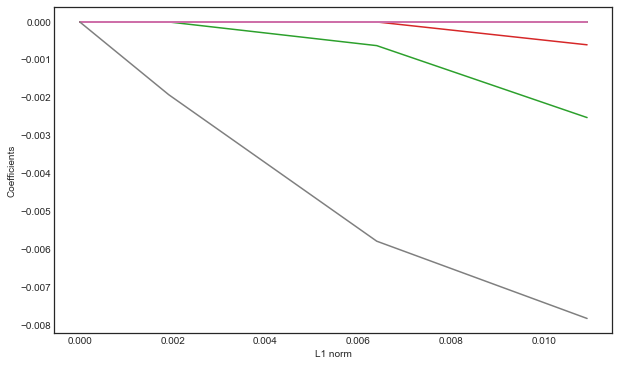

In [470]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

In [472]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(scale(xvalid2), yvalid2_dm)

ElasticNet(n_splits=10, scoring='mean_squared_error')

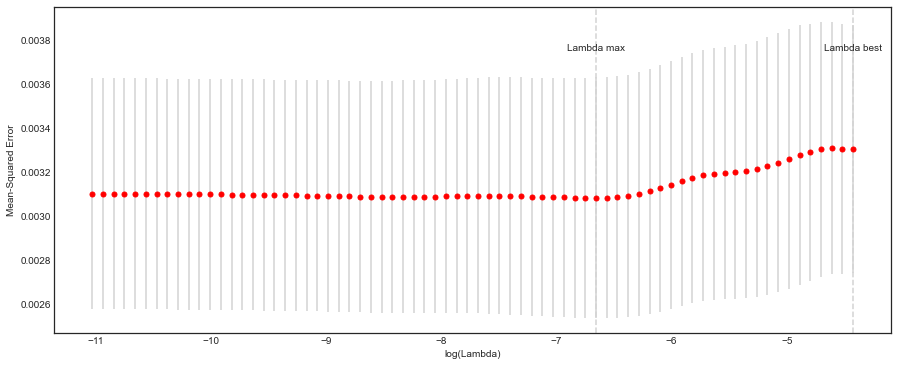

In [473]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [474]:
pd.Series(lasso3.coef_path_[:,lasso3.lambda_max_inx_], index=xtrain2.columns)

dp      0.000000
ep      0.006192
bm      0.000000
ntis   -0.000146
tbl    -0.027292
tms    -0.009866
dfy     0.016979
svar    0.001201
dtype: float64

In [475]:
##Elastic net(alpha=0)~Ridge
grid = 10**np.linspace(10,-2,100)
ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(scale(xtrain2), ytrain2_dm)

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]))

In [477]:
ridge5 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge5.fit(scale(xvalid2), yvalid2_dm)

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           scoring='mean_squared_error', tol=1e-12)

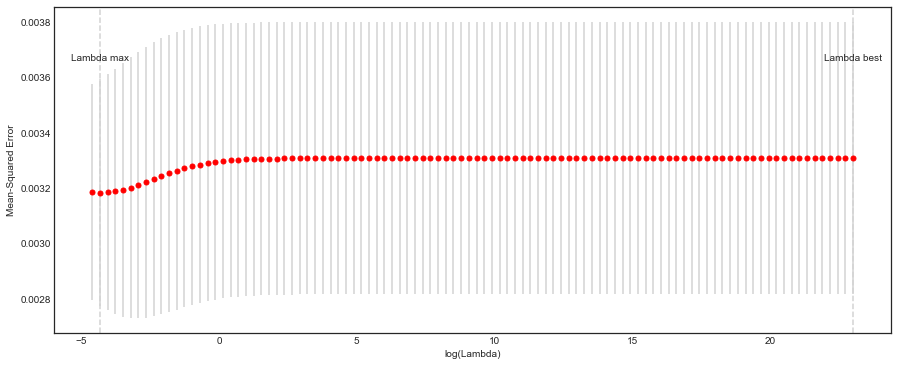

In [478]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [479]:
pd.Series(ridge5.coef_path_[:,ridge5.lambda_max_inx_], index=xtrain2.columns)

dp     -0.004667
ep      0.005219
bm      0.003484
ntis   -0.000804
tbl    -0.016603
tms    -0.003497
dfy     0.011002
svar    0.003441
dtype: float64

In [448]:
##Elastic net
elastic_net=gln.ElasticNet(alpha=0.5,scoring='mean_squared_error', n_splits=10)
elastic_net.fit(scale(xtrain2),ytrain2_dm)

ElasticNet(alpha=0.5, n_splits=10, scoring='mean_squared_error')

In [450]:
pd.Series(np.round(elastic_net.coef_path_[:,elastic_net.lambda_max_inx_], decimals=3), index=xtrain2.columns)

dp     -0.002
ep      0.020
bm     -0.009
ntis   -0.003
tbl    -0.036
tms    -0.016
dfy     0.022
svar    0.002
dtype: float64

In [451]:
##PCR
pca = PCA()
Xtrain2_reduced = pca.fit_transform(scale(xtrain2))
Xvalid2_reduced = pca.fit_transform(scale(xvalid2))
Xtest2_reduced=pca.fit_transform(scale(xtest2))
print(pca.components_.shape)

(8, 8)


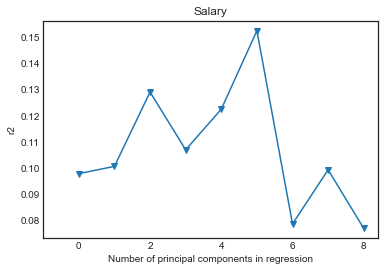

In [454]:
# 10-fold CV, with shuffle
n = len(Xvalid2_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), yvalid2, cv=kf_10, scoring='r2').mean()    
mse.append(score)

# Calculate MSE using CV for the 8 principle components, adding one component at the time.
for i in np.arange(1, 9):
    score = -1*model_selection.cross_val_score(regr, Xvalid2_reduced[:,:i], yvalid2, cv=kf_10, scoring='r2').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('r2')
plt.title('Salary')
plt.xlim(xmin=-1);

In [467]:
#Note that PCR cannot reduce the features dimension, so this case is reduced to OLS+H
huber3 = HuberRegressor().fit(scale(xtrain2), ytrain2_dm)
pd.Series(huber3.coef_, index=xtrain2.columns)

dp     -0.002231
ep      0.007414
bm     -0.033737
ntis   -0.016622
tbl     0.005006
tms     0.005489
dfy     0.020655
svar   -0.011843
dtype: float64

In [30]:
rdata=z11
rdata["DATE"]=rdata["DATE"]//10000

In [32]:
em=[]
for i in rdata["DATE"].unique():
    take=rdata[rdata["DATE"]==i]
    take2=take.drop(columns=["DATE","permno"])
    new=take2.mean()
    em.append(new.values)
rd=pd.DataFrame(em,columns=take2.columns)
rd

           mvel1       RET        prc         SHROUT      beta    betasq  \
0   1.668993e+05 -0.012880  35.056375    4449.271366  1.002461  1.186885   
1   1.721024e+05  0.040115  36.170427    4657.118782  1.001678  1.203861   
2   2.214747e+05  0.012295  42.549650    5104.422548  1.003424  1.214418   
3   2.173623e+05 -0.000643  36.195354    5705.916572  0.998905  1.211830   
4   2.572555e+05  0.022267  41.076233    6098.088869  1.005420  1.224644   
5   1.765266e+05 -0.008687  28.280909    5456.497859  0.986727  1.109777   
6   1.428883e+05  0.012517  25.316197    4767.343196  0.984762  1.135361   
7   1.628407e+05  0.014102  26.399268    5049.454643  1.005602  1.287486   
8   1.801423e+05  0.026280  27.328923    5390.431257  1.011778  1.311801   
9   1.827219e+05 -0.004501  26.439333    5685.532972  0.996097  1.334181   
10  2.061124e+05  0.049806  30.334589    5941.043762  0.990961  1.254380   
11  2.348411e+05  0.031097  33.699282    6426.972184  0.992662  1.221757   
12  2.411464

In [197]:
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import ElasticNet

In [633]:
ols=[]
olsH=[]
ols3H=[]
for i in range(30):
    rtrain=rd.iloc[0:(17+i)]##from the first year to the 18+i th year
    rvalid=rd.iloc[(18+i):(18+i+11)]##from the 19th year to the 30th year
    rtest=rd.iloc[18+i+12]##the 31+i th year
    xtn=rtrain.drop(columns=["RET"])
    ytn=rtrain["RET"]
    xvd=rvalid.drop(columns=["RET"])
    yvd=rvalid["RET"]
    xtt=rtest.drop(columns=["RET"])
    ytt=rtest["RET"]
    mtn=ytn.mean()
    mvd=yvd.mean()
    mtt=ytt.mean()
    ytn_dm=ytn-mtn
    yvd_dm=yvd-mvd
    ytt_dm=ytt-mtt
    ##OLS
    regr = linear_model.LinearRegression()
    regr.fit(scale(xtn),ytn_dm)
    s=pd.Series(np.abs(regr.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    ols.append(table)
    ##OLS+H
    huber = HuberRegressor().fit(scale(xtn), ytn_dm)
    s=pd.Series(np.abs(huber.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    olsH.append(table)
    ##OLS3+H
    X3train=rtrain[["mvel1","bm","mom1m"]]
    X3test=rtrain[["mvel1","bm","mom1m"]]
    huber_ols3 = HuberRegressor().fit(scale(X3train), ytn_dm)
    s=pd.Series(np.abs(huber_ols3.coef_),index=["mvel1","bm","mom1m"])
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    ols3H.append(table)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

In [634]:
ls=[]
en=[]
for i in range(30):
    rtrain=rd.iloc[0:(17+i)]##from the first year to the 18+i th year
    rvalid=rd.iloc[(18+i):(18+i+11)]##from the 19th year to the 30th year
    rtest=rd.iloc[18+i+12]##the 31+i th year
    xtn=rtrain.drop(columns=["RET"])
    ytn=rtrain["RET"]
    xvd=rvalid.drop(columns=["RET"])
    yvd=rvalid["RET"]
    xtt=rtest.drop(columns=["RET"])
    ytt=rtest["RET"]
    mtn=ytn.mean()
    mvd=yvd.mean()
    mtt=ytt.mean()
    ytn_dm=ytn-mtn
    yvd_dm=yvd-mvd
    ytt_dm=ytt-mtt
    ##Lasso
    lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
    lassocv.fit(scale(xvd), yvd_dm)
    lasso = Lasso(max_iter=10000)
    coefs = []
    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(scale(xtn), ytn_dm)
    s=pd.Series(np.abs(lasso.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    ls.append(table)
    ##Elastic net
    elastic_net=gln.ElasticNet(alpha=0.5,scoring='mean_squared_error', n_splits=10)
    elastic_net.fit(scale(xtn),ytn_dm)
    s=pd.Series(np.abs(np.round(elastic_net.coef_path_[:,elastic_net.lambda_max_inx_])),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    en.append(table)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Library/Frameworks/Py

In [635]:
olsfinal=[]
for i in xtn.columns:
    r=0
    for k in ols:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    olsfinal.append(10000-r)

In [636]:
rols=pd.DataFrame(olsfinal,index=xtn.columns)

In [637]:
rols

              0
mvel1      9275
prc        8379
SHROUT     8536
beta       7537
betasq     8122
...         ...
std_turn   7776
zerotrade  8094
sic2       8995
bm         8183
bm_ia      7974

[98 rows x 1 columns]

In [638]:
olsHfinal=[]
for i in xtn.columns:
    r=0
    for k in olsH:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    olsHfinal.append(10000-r)

In [639]:
rolsH=pd.DataFrame(olsHfinal,index=xtn.columns)

In [640]:
lsfinal=[]
for i in xtn.columns:
    r=0
    for k in ls:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    lsfinal.append(10000-r)

In [641]:
rls=pd.DataFrame(lsfinal,index=xtn.columns)

In [642]:
enfinal=[]
for i in xtn.columns:
    r=0
    for k in en:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    enfinal.append(10000-r)

In [643]:
ren=pd.DataFrame(enfinal,index=xtn.columns)

In [644]:
data=pd.concat([rols,rolsH,rls,ren],axis=1)

In [645]:
data.columns=["OLS","OLS+H","PLS","ENet"]

In [646]:
data

            OLS  OLS+H   PLS   ENet
mvel1      9275   9333  9326  10000
prc        8379   9298  7969   7900
SHROUT     8536   8696  8122   7930
beta       7537   7296  7801   7960
betasq     8122   8200  7893   7990
...         ...    ...   ...    ...
std_turn   7776   7602  9015   9190
zerotrade  8094   8993  9036   9220
sic2       8995   9205  9051   9250
bm         8183   7682  8091   7840
bm_ia      7974   8002  7920   7090

[98 rows x 4 columns]

In [647]:
gg=pd.DataFrame(scale(data),index=xtn.columns,columns=["OLS","OLS+H","PLS","ENet"])

In [648]:
gg.to_csv('hp.csv', index=True)

In [652]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(20,50))
sns.heatmap(gg, annot=False, vmax=None,linecolor='white', square=False, cmap="Blues")
plt.show()

In [200]:
##macro predictor
mac=pd.read_csv("PredictorData2020.csv")

In [205]:
mac["yyyymm"]=mac["yyyymm"]//100

/var/folders/7y/wct1r0j95ys72y16qmsg9llc0000gn/T/ipykernel_25043/3569145680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mac["yyyymm"]=mac["yyyymm"]//100


In [208]:
em=[]
for i in mac["yyyymm"].unique():
    take=mac[mac["yyyymm"]==i]
    take2=take.drop(columns=["yyyymm"])
    new=take2.mean()
    em.append(new.values)
rmac=pd.DataFrame(em,columns=take2.columns)
rmac

          dp        ep        bm      ntis       tbl       tms       dfy  \
0  -1.402290 -1.111404  0.601054  0.033023  0.032490  0.002640  0.008430   
1  -1.425563 -1.191499  0.601189  0.020951  0.017708  0.016808  0.009392   
2  -1.508173 -1.245031  0.484283  0.027264  0.033858  0.008075  0.006717   
3  -1.457759 -1.225520  0.546261  0.025160  0.028833  0.011667  0.007792   
4  -1.531406 -1.332626  0.525680  0.023457  0.023542  0.016633  0.007250   
5  -1.475006 -1.250506  0.606469  0.026683  0.027733  0.012400  0.006950   
6  -1.504155 -1.260372  0.556384  0.012272  0.031592  0.009142  0.005967   
7  -1.532172 -1.274124  0.504531  0.019727  0.035467  0.006733  0.004225   
8  -1.528987 -1.259462  0.457994  0.017297  0.039492  0.003383  0.003725   
9  -1.474024 -1.190615  0.523244  0.017736  0.048625 -0.001342  0.005350   
10 -1.501331 -1.234595  0.536908  0.010330  0.043067  0.007283  0.007217   
11 -1.516250 -1.247083  0.528502  0.015802  0.053383  0.001125  0.007608   
12 -1.493808

In [604]:
mols=[]
molsH=[]
mls=[]
men=[]
for i in range(30): 
    xtn=rmac.iloc[0:(17+i)]##from the first year to the 18+i th year
    xvd=rmac.iloc[(18+i):(18+i+11)]##from the 19th year to the 30th year
    xtt=rmac.iloc[18+i+12]##the 31+i th year
    rtrain=rd.iloc[0:(17+i)]##from the first year to the 18+i th year
    rvalid=rd.iloc[(18+i):(18+i+11)]##from the 19th year to the 30th year
    rtest=rd.iloc[18+i+12]##the 31+i th year
    ytn=rtrain["RET"]
    yvd=rvalid["RET"]
    ytt=rtest["RET"]
    mtn=ytn.mean()
    mvd=yvd.mean()
    mtt=ytt.mean()
    ytn_dm=ytn-mtn
    yvd_dm=yvd-mvd
    ytt_dm=ytt-mtt
    ##OLS
    regr = linear_model.LinearRegression()
    regr.fit(scale(xtn),ytn_dm)
    s=pd.Series(np.abs(regr.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    mols.append(table)
    ##OLS+H
    huber = HuberRegressor().fit(scale(xtn), ytn_dm)
    s=pd.Series(np.abs(huber.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    molsH.append(table)
    ##Lasso
    lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
    lassocv.fit(scale(xvd), yvd_dm)
    lasso = Lasso(max_iter=10000)
    coefs = []
    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(scale(xtn), ytn_dm)
    s=pd.Series(np.abs(lasso.coef_),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    mls.append(table)
    ##Elastic net
    elastic_net=gln.ElasticNet(alpha=0.5,scoring='mean_squared_error', n_splits=10)
    elastic_net.fit(scale(xtn),ytn_dm)
    s=pd.Series(np.abs(np.round(elastic_net.coef_path_[:,elastic_net.lambda_max_inx_])),index=xtn.columns)
    s=s.sort_values()
    rank=pd.DataFrame(range(len(s)),index=s.index)
    table=pd.concat([rank,pd.DataFrame(s.index,index=s.index)],axis=1)
    table.index=range(len(s))
    table.columns=["rank","feature"]
    men.append(table)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1473801097417287e-07, tolerance: 1.671489111238175e-07
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.206516462245538e-07, tolerance: 1.671489111238175e-07
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4496839168693047e-07, tolerance: 1.671489111238175e-07
  model = c

In [605]:
molsfinal=[]
for i in xtn.columns:
    r=0
    for k in mols:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    molsfinal.append(200-r)

In [606]:
rols=pd.DataFrame(molsfinal,index=xtn.columns)

In [607]:
molsHfinal=[]
for i in xtn.columns:
    r=0
    for k in molsH:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    molsHfinal.append(200-r)

In [608]:
rolsH=pd.DataFrame(molsHfinal,index=xtn.columns)

In [609]:
mlsfinal=[]
for i in xtn.columns:
    r=0
    for k in mls:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    mlsfinal.append(200-r)

In [610]:
rls=pd.DataFrame(mlsfinal,index=xtn.columns)

In [611]:
menfinal=[]
for i in xtn.columns:
    r=0
    for k in men:
            temp=k[k["feature"]==i]
            r=r+int(temp["rank"].values)
    menfinal.append(200-r)

In [612]:
ren=pd.DataFrame(menfinal,index=xtn.columns)

In [613]:
data2=pd.concat([rols,rolsH,rls,ren],axis=1)

In [614]:
gg=pd.DataFrame(scale(data2),index=xtn.columns,columns=["OLS","OLS+H","PLS","ENet"])

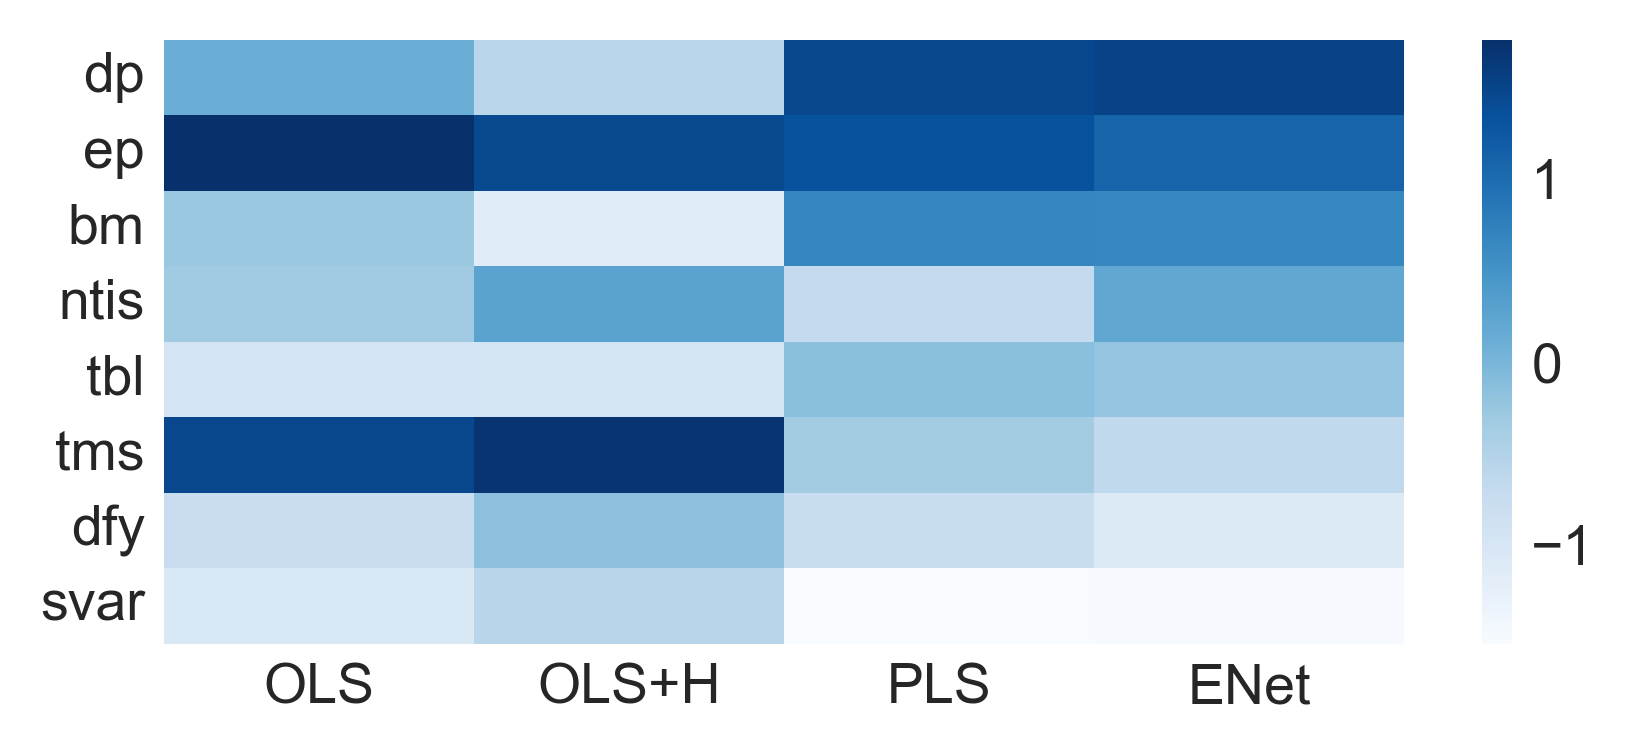

In [618]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(5,2))
sns.heatmap(gg, annot=False, vmax=None,linecolor='white', square=False, cmap="Blues")
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 400 #分辨率
plt.show()

In [376]:
gg.to_csv('hp(macro).csv', index=True)